In [85]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [86]:
import geomloss
import matplotlib.pyplot as plt
import numpy as np
import ot
import pandas as pd
import scipy.stats as st
import seaborn
import torch

In [87]:
cpu = torch.device('cpu')

$X \sim \sum_i w_i, \delta_{X_i}$ where the $X_i$'s are i.i.d. $U([-2, 2])$ and $w_i \propto f(X_i)$ where $f$ is the pdf of a normal distribution $ \mathcal{N}(1, 1)$

In [365]:
randomState = np.random.RandomState(42)
N = 500

In [447]:
X = randomState.uniform(-2, 2, N)

loc=0.5
scale=1.
weights = st.norm.pdf(X, loc=loc, scale=scale)
weights /= weights.sum()

In [448]:
uniform_weights = np.full(N, 1/N)

Illustration of the regularised OT problem:

In [449]:
exactTransport = ot.bregman.empirical_sinkhorn(X[:, None], X[:, None], 1e-2, weights, uniform_weights)
# sadly the Earth moving distance doesn't work

In [450]:
torch_uniform_weights = torch.from_numpy(uniform_weights).to(cpu)
torch_X = torch.from_numpy(X[:, None]).to(cpu)
torch_weights = torch.from_numpy(weights).to(cpu)

In [451]:
def transport_from_potentials(x, f, g, w, eps):
    C = (x.T - x) ** 2 / 2.
    FG = f.T + g
    T = torch.exp((FG - C)/eps**2) * w.unsqueeze(1)
    return T.T @ x, (T.T / N ).sum(axis=1)

In [452]:
epsilons = [0.01, 0.05, 0.1, 0.5]
approximateTransports = []
for eps in epsilons:
    biasedSampleLoss = geomloss.SamplesLoss(reach=None, potentials=True, debias=False, scaling=0.9, blur=eps)
    alpha, beta = biasedSampleLoss(torch_weights, torch_X, torch_uniform_weights, torch_X)
    
    approximateTransports.append(transport_from_potentials(torch_X, alpha, beta, torch_weights, eps))

In [453]:
linspace = np.sort(np.random.uniform(-3, 3, 10000))
theoretical_unweighted = st.norm.pdf(linspace, loc=loc, scale=scale)


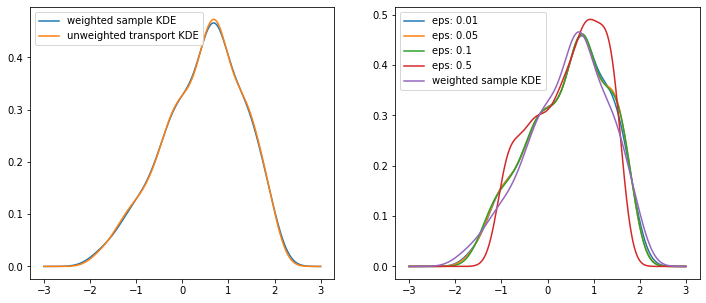

In [454]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

weighted_sample_kde = st.kde.gaussian_kde(X, weights=weights)
exact_transport_kde = st.kde.gaussian_kde((exactTransport.T * N) @ X)

_ = axes[0].plot(linspace, weighted_sample_kde(linspace), label='weighted sample KDE')
_ = axes[0].plot(linspace, exact_transport_kde(linspace), label='unweighted transport KDE')

dataframeWeights = []

for eps, plan in zip(epsilons, approximateTransports):
    approx_transport_kde = st.kde.gaussian_kde(plan[0].detach().numpy().squeeze(), weights=plan[1].detach().numpy())
    dataframeWeights.append(pd.Series(data=plan[1].detach().numpy(), name=eps))
    _ = axes[1].plot(linspace, approx_transport_kde(linspace), label=f'eps: {eps}')
    
_ = axes[1].plot(linspace, weighted_sample_kde(linspace), label='weighted sample KDE')


_ = axes[0].legend(loc='upper left')
_ = axes[1].legend(loc='upper left')

fig.savefig( 'KDEIllustration.png')

In [456]:
print((pd.concat(dataframeWeights, axis=1).describe(percentiles=[0.1, 0.5, 0.9]) * 1e3).to_latex(float_format='{0:.3f}'.format))

\begin{tabular}{lrrrr}
\toprule
{} &       0.01 &       0.05 &       0.10 &       0.50 \\
\midrule
count & 500000.000 & 500000.000 & 500000.000 & 500000.000 \\
mean  &      1.995 &      1.998 &      1.998 &      2.001 \\
std   &      0.152 &      0.099 &      0.089 &      0.049 \\
min   &      1.563 &      1.692 &      1.691 &      1.863 \\
10\%   &      1.801 &      1.874 &      1.875 &      1.919 \\
50\%   &      2.009 &      2.020 &      2.023 &      2.015 \\
90\%   &      2.197 &      2.106 &      2.096 &      2.050 \\
max   &      2.347 &      2.135 &      2.116 &      2.052 \\
\bottomrule
\end{tabular}

